In [23]:
from fastbook import *
from fastcore.all import *
from fastai.vision.all import *
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
import os
import cv2
import seaborn as sns

# Preprocessing label maps (.pbtxt)

In [12]:
def load_label_map(label_map_path, exclude_label="Lindsay-s Nail"):
    with open(label_map_path, "r") as file:
        content = file.read()

    label_map = {}
    matches = re.findall(r'name:\s*\"(.+?)\",\s*id:\s*(\d+),', content)  # Adjusted regex

    for match in matches:
        label_name = match[0]
        label_id = int(match[1])

        if label_name != exclude_label:  # Skip Lindsay's Nail because it only has 1 item
            label_map[label_id - 1] = label_name  # Convert to 0-based index

    return label_map

# Path to label map
label_map_path = "dataset/train/Diseases_label_map.pbtxt"
CLASS_LABELS = load_label_map(label_map_path)

# Debug: Print Loaded Labels
if CLASS_LABELS:
    print("✅ Loaded Labels (without Lindsay's Nail):", CLASS_LABELS)
else:
    print("❌ ERROR: No labels loaded. Check the pbtxt file path or format!")


✅ Loaded Labels (without Lindsay's Nail): {0: 'Acral Lentiginous Melanoma', 1: 'Beaus Line', 2: 'Blue Finger', 3: 'Clubbing', 4: 'Healthy Nail', 5: 'Koilonychia', 7: 'Muehrckes Lines', 8: 'Onychogryphosis', 9: 'Pitting', 10: 'Terry-s Nail'}


# Converting to Split Set (Test, Train, Validation)
This code converts the .tfrecords from the dataset2 into a Directory-Based Dataset which is split into the ``train``, ``test``, and ``valid`` sets. The output directory is at ``converted_dataset``

In [15]:
# Paths to datasets
tfrecord_paths = {
    "train": "dataset/train/Diseases.tfrecord",
    "valid": "dataset/valid/Diseases.tfrecord",
    "test": "dataset/test/Diseases.tfrecord",
}

output_dirs = {
    "train": "converted_dataset/train",
    "valid": "converted_dataset/valid",
    "test": "converted_dataset/test",
}

# Ensure output directories exist
for split, output_dir in output_dirs.items():
    os.makedirs(output_dir, exist_ok=True)

def _parse_tfrecord(example_proto):
    feature_description = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/format": tf.io.FixedLenFeature([], tf.string),
        "image/object/class/label": tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    # Decode image
    image = tf.io.decode_jpeg(example["image/encoded"], channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.uint8).numpy()

    # Convert sparse tensor to dense
    labels = tf.sparse.to_dense(example["image/object/class/label"]).numpy()

    # Exclude missing labels
    if len(labels) > 0:
        label_id = labels[0] - 1  # Convert to 0-based index
        label_name = CLASS_LABELS.get(label_id)

        # Exclude images with missing or unknown labels
        if label_name is None:
            return None

        return image, label_name
    return None



# Process all datasets
for split, tfrecord_path in tfrecord_paths.items():
    output_dir = output_dirs[split]
    print(f"🔄 Processing {split} set...")

    raw_dataset = tf.data.TFRecordDataset([tfrecord_path])
    for i, raw_record in enumerate(raw_dataset):
        parsed = _parse_tfrecord(raw_record)
        if parsed:
            image, label_name = parsed
            class_dir = os.path.join(output_dir, label_name)
            os.makedirs(class_dir, exist_ok=True)
            filename = os.path.join(class_dir, f"{i}.jpg")
            cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Fix color issue

    print(f"✅ {split.capitalize()} set done! Images saved in: {output_dir}")

print("🎉 All datasets processed successfully!")

🔄 Processing train set...


2025-03-31 17:50:33.618918: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


✅ Train set done! Images saved in: converted_dataset/train
🔄 Processing valid set...
✅ Valid set done! Images saved in: converted_dataset/valid
🔄 Processing test set...
✅ Test set done! Images saved in: converted_dataset/test
🎉 All datasets processed successfully!


# Combined Set
This code converts the .tfrecords into one whole Directory-Based dataset. The output is at ``combined_dataset``

In [16]:
# Paths to TFRecord files
tfrecord_paths = {
    "train": "dataset/train/Diseases.tfrecord",
    "valid": "dataset/valid/Diseases.tfrecord",
    "test": "dataset/test/Diseases.tfrecord",
}

# Output folder for FastAI
output_dir = "combined_dataset"
os.makedirs(output_dir, exist_ok=True)


# Process all datasets into one folder
for split, tfrecord_path in tfrecord_paths.items():
    print(f"🔄 Processing {split} set...")

    raw_dataset = tf.data.TFRecordDataset([tfrecord_path])
    for i, raw_record in enumerate(raw_dataset):
        parsed = _parse_tfrecord(raw_record)
        if parsed:
            image, label_name = parsed
            class_dir = os.path.join(output_dir, label_name)
            os.makedirs(class_dir, exist_ok=True)
            filename = os.path.join(class_dir, f"{split}_{i}.jpg")  # Prefix to avoid conflicts
            cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Fix color issue

    print(f"✅ {split.capitalize()} set done! Images saved in: {output_dir}")

print("🎉 All datasets processed successfully!")


🔄 Processing train set...
✅ Train set done! Images saved in: combined_dataset
🔄 Processing valid set...
✅ Valid set done! Images saved in: combined_dataset
🔄 Processing test set...
✅ Test set done! Images saved in: combined_dataset
🎉 All datasets processed successfully!


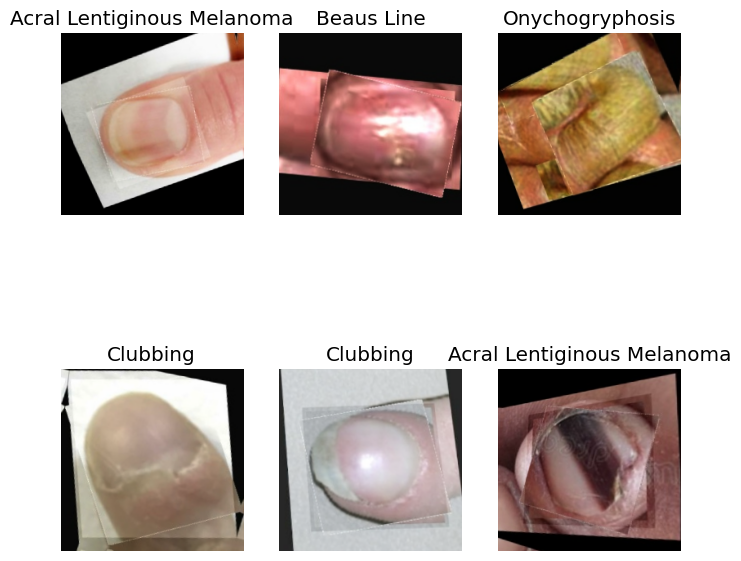

In [ ]:
path = Path("converted_dataset")

data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name="train", valid_name="valid"),
    get_y=parent_label, 
    item_tfms=[Resize(224)], 
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)] 
)

dls = data_block.dataloaders(path, bs=16)

dls.show_batch(max_n=6, figsize=(8, 8))

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.945229,1.554793,0.448393,03:00


epoch,train_loss,valid_loss,error_rate,time
0,1.179648,1.047220,0.316413,04:06
1,0.767067,0.752016,0.235195,04:11
2,0.508110,0.684707,0.204738,04:16


In [25]:
test_path = Path("converted_dataset/test") 
test_dls = dls.test_dl(get_image_files(test_path))

preds, _ = learn.get_preds(dl=test_dls)
y_pred = preds.argmax(dim=1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_test = [learn.dls.vocab.o2i[parent_label(f)] for f in get_image_files(test_path)]

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision Score: {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"Recall Score: {recall_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")


✅ Accuracy Score: 0.7590
✅ Precision Score: 0.7477
✅ Recall Score: 0.7279
✅ F1 Score: 0.7276


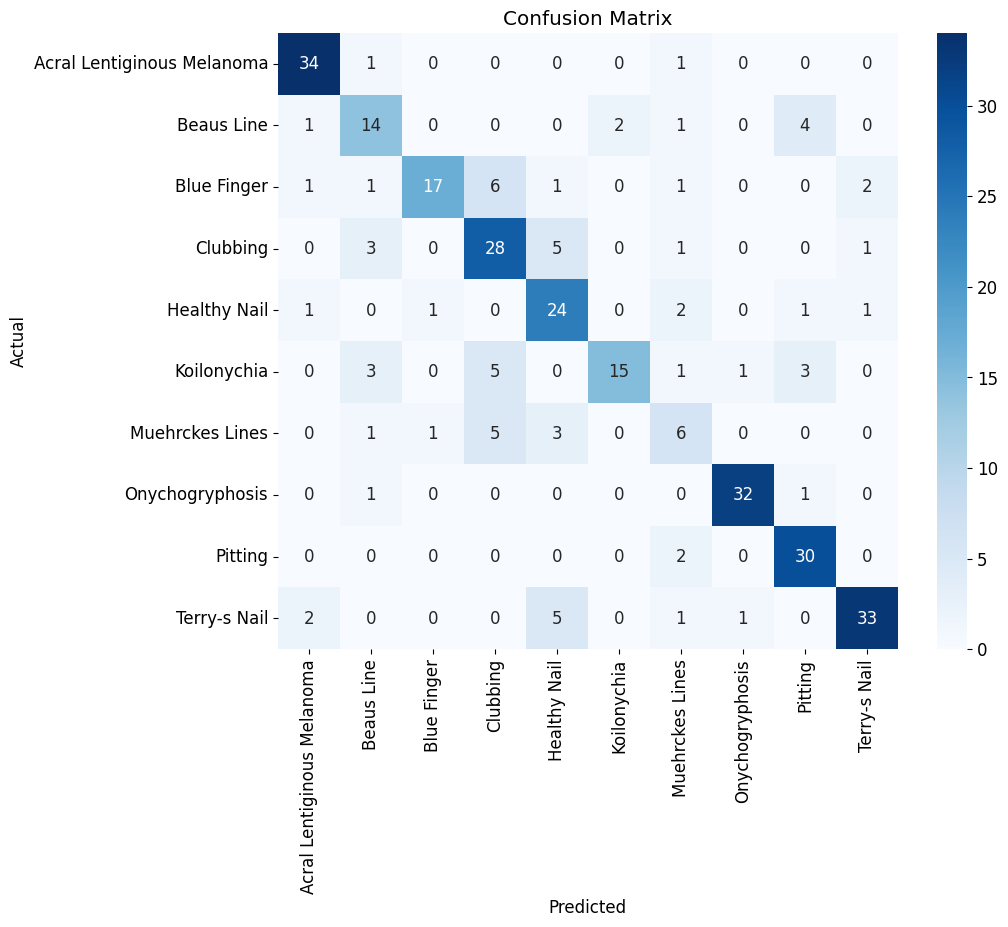

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = learn.dls.vocab 

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


🟢 Detected Fingernail Disease: Clubbing (Confidence: 0.9980)

🔍 Classification Probabilities:
Acral Lentiginous Melanoma: 0.00 %
Beaus Line: 0.02 %
Blue Finger: 0.01 %
Clubbing: 99.80 %
Healthy Nail: 0.02 %
Koilonychia: 0.01 %
Muehrckes Lines: 0.02 %
Onychogryphosis: 0.01 %
Pitting: 0.02 %
Terry-s Nail: 0.10 %


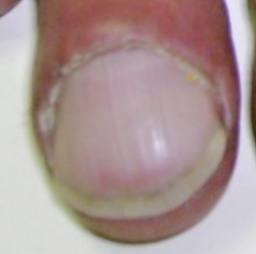

In [ ]:
prediction = "finger_04.jpg"

predicted_label, index, probs = learn.predict(PILImage.create(prediction))
print(f"\nDetected Fingernail Disease: {predicted_label} (Confidence: {probs[index]:.4f})")

class_labels = learn.dls.vocab

print("\nClassification Probabilities:")
for i, label in enumerate(class_labels):
    print(f"{label}: {probs[i] * 100:.2f} %")

Image.open(prediction).to_thumb(256, 256)